In [362]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [363]:
data_path='data/ThaiTisco23.csv'
trade_sheet='THAI-Mar-May23'

# data_path=r'D:\PythonDev\MyQuantFinProject\Data\thai_fund.csv'
trade_plan_path='data/Config-BuySellTrade.xlsx'

# excludeFund=['ASP-T12','KKP-TQG']
excludeFund=[]


report_path=f'report/{trade_sheet}.xlsx'

noFee=False
fee_sheet='Fee'

start_date='2023-03-01'
end_date='2023-06-02'

# trade_sheet='BuySell_Buy_Hold'
# report_path=f'report/BuySell_4ETFFunds.xlsx'





# Read Price CSV

In [364]:
df=pd.read_csv(data_path,parse_dates=['Date/Time'],dayfirst=True)
df.columns=['symbol','date','price']
df=df.query('date>=@start_date and date<=@end_date')
df.info()
print(df.sample(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 41 to 305
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   symbol  183 non-null    object        
 1   date    183 non-null    datetime64[ns]
 2   price   183 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 5.7+ KB
         symbol       date  price
47   TISCOFLEXP 2023-03-10  56.24
61   TISCOFLEXP 2023-03-30  56.50
170   TISCOMS-A 2023-04-11  20.05
287       TSF-A 2023-05-09  77.13
281       TSF-A 2023-04-26  73.80
160   TISCOMS-A 2023-03-27  20.09
268       TSF-A 2023-04-04  78.17
191   TISCOMS-A 2023-05-17  19.50
278       TSF-A 2023-04-21  75.13
73   TISCOFLEXP 2023-04-20  54.49


# List Symbol and Plot Chart

In [365]:
list_symbols=list(df['symbol'].unique())
list_symbols=[ f for f in list_symbols if f not in excludeFund ]
list_symbols
# list_symbols=['ACWI']


['TISCOFLEXP', 'TISCOMS-A', 'TSF-A']

['TISCOFLEXP', 'TISCOMS-A', 'TSF-A']
==============================TISCOFLEXP==============================


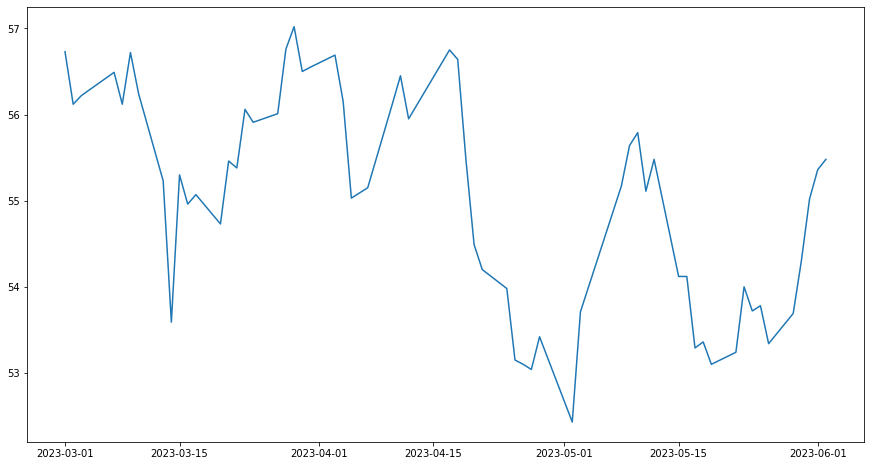

==============================TISCOMS-A==============================


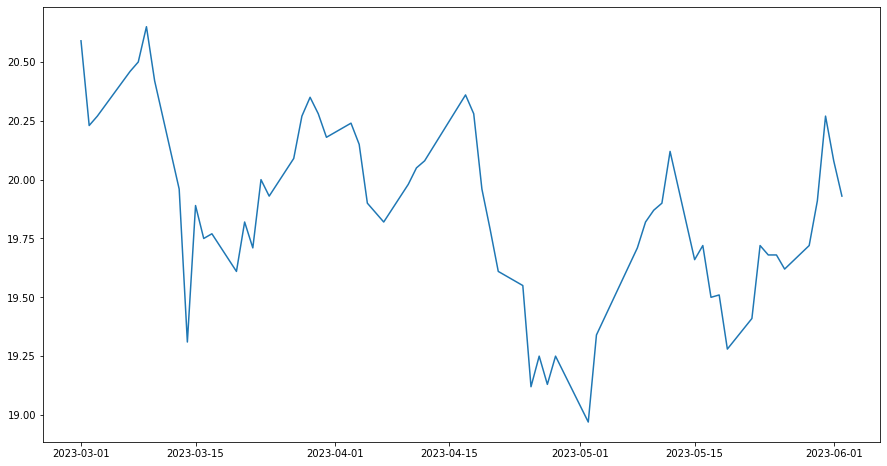

==============================TSF-A==============================


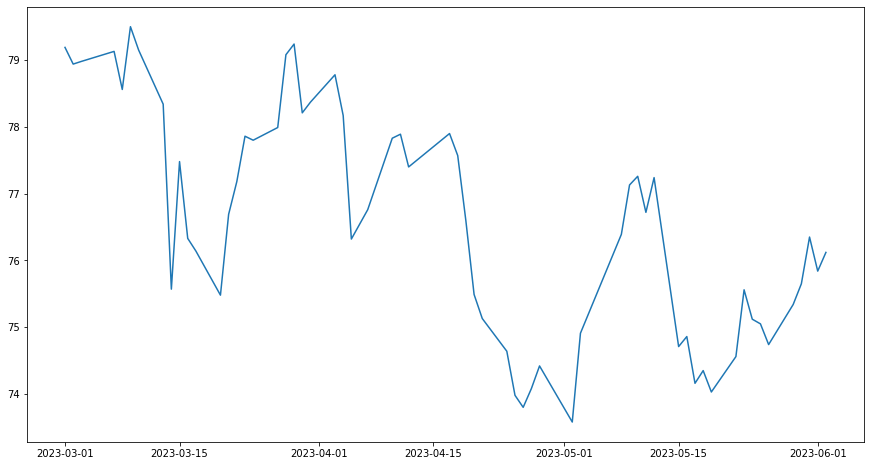

In [366]:
print(list_symbols)
for  symbol in list_symbols:
    print(f"=============================={symbol}==============================")
    dfFund=df.query('symbol==@symbol')
    plt.figure(figsize=(15, 8))
    plt.plot(dfFund['date'],dfFund['price'])
    plt.show()

# Get Trade Data and Fee

In [367]:
# read feeon 
dfAssetInfo=pd.read_excel(trade_plan_path,engine="openpyxl",sheet_name=fee_sheet,\
                    index_col='symbol', dtype ={'buy_fee_pct': np.float64,'sell_fee_pct': np.float64})

# check where  fund fee  in portfolio  are avaible?
dfNoFeeInfo= [ item for item in list_symbols if item not in list(dfAssetInfo.index)]
dfAssetInfo=dfAssetInfo.loc[list(list_symbols),:]

if noFee==True:
    dfAssetInfo[['buy_fee_pct','sell_fee_pct']]=0
    
print("fee info")
print(dfAssetInfo) 
# For instance   AAXJ Price=100 but we need to pay 101 $

fee info
            buy_fee_pct  sell_fee_pct
symbol                               
TISCOFLEXP         1.00           0.0
TISCOMS-A          1.00           0.0
TSF-A              1.05           0.0


In [368]:
dfPlan=pd.read_excel(trade_plan_path,engine="openpyxl",sheet_name=trade_sheet, \
                     parse_dates=['trade_date'],dtype ={'portion_pct': np.float64})

#total buy portion is equal or greater than sell portion
buy_sum_act=dfPlan.query("action=='b'").portion_pct.sum()
sell_sum_act=dfPlan.query("action=='s'").portion_pct.sum()

all_portion=0

In [369]:
if buy_sum_act<sell_sum_act:
  raise Exception("Not allow Buy <= Sell")   
else:
    if buy_sum_act>sell_sum_act:
       print("=============Calculate the last portion to be sellable")
       sellAllAtNow=buy_sum_act-sell_sum_act 
       dfLastPrice=pd.DataFrame(columns=list(dfPlan.columns), data=[ [df['date'].max(),sellAllAtNow,'s']])
       print(dfLastPrice)
       dfPlan=pd.concat([dfPlan,dfLastPrice])
       dfPlan=dfPlan.reset_index(drop=True)

    tradeDateList= [ d for d in list(dfPlan['trade_date']) ]    
    all_portion=buy_sum_act   
    print(f"portion = {all_portion} on")
    
print("==========================Summarize All Trade==========================================")
print(f"No Buy/Sell {dfPlan.groupby(['action']).size()}")
print(dfPlan)

portion = 100.0 on
==========================Summarize All Trade==========================================
No Buy/Sell action
b    4
s    2
dtype: int64
  trade_date  portion_pct action
0 2023-03-21         25.0      b
1 2023-04-28         25.0      b
2 2023-05-08         25.0      b
3 2023-05-23         25.0      b
4 2023-06-01         50.0      s
5 2023-06-02         50.0      s


In [370]:
# To make it easier for use to understand portfolio transatoin 
TotalBudget=100*1000
rrr=TotalBudget % all_portion
if rrr !=0 :
  raise Exception(f"Your Budget {TotalBudget} is  not proportional  Portion with {all_portion}")
else:
  print(f"Your Budget {TotalBudget} is  proportional  Portion with {all_portion}")

Your Budget 100000 is  proportional  Portion with 100.0


# Custom Function

In [371]:
# figure out the amount of qty from total fund total value
def get_qty_buy(item):
    xCost=(item['portion_pct']/all_portion)*TotalBudget  
    xPrice=item['price_on_fee']
    qty=xCost/xPrice
    return qty

# figure the amount of  qty out  from total qty
def get_qty_sell(item,TotalQty):  
    qty=(item['portion_pct']/all_portion)*TotalQty
    return qty

In [372]:
def set_fee_by_action(item):
  x=item['symbol']  
  if item['action']=='b':
    fee_type='buy_fee_pct'
  elif  item['action']=='s':
    fee_type='sell_fee_pct'
  try:
     return dfAssetInfo.loc[x,fee_type]
  except Exception as ex:
     print(f"Error : no {x} to get fund fee")
     return 0

In [373]:
dict_dfTran={}
dfSummary=pd.DataFrame(columns=['Symbol','BuyValue','AvgBuyPrice','SellValue','AvgSellPrice','PL','Percent_PL'])

dfSummary

,Symbol,BuyValue,AvgBuyPrice,SellValue,AvgSellPrice,PL,Percent_PL


In [374]:
#https://www.w3resource.com/pandas/dataframe/dataframe-apply.php

for symbol in list_symbols:
    print(f"*******************{symbol}*******************")

    dfBS=df[ (df['symbol']==symbol) & (df['date'].isin(tradeDateList))]
    # if len(tradeDateList)==len(dfBS):
        
     # Step1  join price data (filter by sybom and the date whiich you have buy/sell action)   
    dfBS=dfBS.merge(dfPlan,how='inner',left_on='date',right_on='trade_date')
     # remove  redundant data  
    dfBS=dfBS.drop(columns=['trade_date'])     
       
    
     # Step2 calculate fee function
    dfBS['fee']=dfBS.apply(set_fee_by_action,axis=1) # 2.1
    
     # The price that allows you to buy the fund is more expensive than the actual asset price  1%  ,other the other had 
     # Buy price*1.0x=??   
    dfBS['price_on_fee']=dfBS.apply(lambda item : item['price']*(1+ (item['fee']/100)) if item['action']=='b' else item['price']*(1-(item['fee']/100)), axis=1)
    dfBS['price_on_fee']=dfBS['price_on_fee'].round(2) #2.2   
    # print(dfBS)
        
     # Step3  To make it easier to calculate and trading sumary in tearm of qty both buy/sell , both use different way
     # we recommend spliting this dataframe  into 2 dataframe
     #  BuyDataFrame and Sell Date , and we will merge both later  
    
    #3.1 query only buy action
    print("======================Buy=======================")
    buyDF=dfBS.query("action=='b'")   
    
    # 3.2 send the  row to function to calculate qty 
    buyDF['qty']=buyDF.apply(get_qty_buy,axis=1) 
    buyDF['value']=round(buyDF['qty']*buyDF['price_on_fee'],0)
    
    
    # 1 is buy (I will take columne to apply cumsum function to calcaulate cumulative return
    buyDF['action_value']=buyDF['value']
    buyDF['action_qty']=buyDF['qty']
    
    # 3.3 Total qty and value and avg
    TotalQty=buyDF['qty'].sum()
    TotalValue=round(buyDF['value'].sum(),0)
    AvgPrice=round(TotalValue/TotalQty,2)
    
    # print(buyDF[['date','portion_pct','value' ,'price','fee','price_on_fee','qty']])
    
    
    # Step4 follow every step corresponidng to prev step#3
    print("=======================Sell=======================")
    # step#4.1
    sellDF=dfBS.query("action=='s'")  
    
    # ste#4.2
    sellDF['qty']=sellDF.apply(get_qty_sell,axis=1,args=(TotalQty,))
    sellDF['value']=round(sellDF['qty']*sellDF['price_on_fee'],0)
    
    # -1 is sell (I will take columne to apply cumsum function to calcaulate cumulative return
    sellDF['action_value']=sellDF['value']*-1
    sellDF['action_qty']=sellDF['qty']*-1
    
    # print(sellDF[['date' ,'portion_pct','value','price','fee','price_on_fee','qty']])
    

    
    print("======================Merge Buy & Sell======================")
    # step 5  concatenate buy and sell dataframe 
    dfTran=pd.concat([buyDF,sellDF],axis=0)
    dfTran=dfTran.sort_values(by=['date'])
    dfTran[['value','action_value']]=dfTran[['value','action_value']].round(0)

    # step 6 accumulate value and qury over entire data since start buying to last record 
    dfTran['net_value']=dfTran['action_value'].cumsum(axis = 0) 
    dfTran['net_qty']=dfTran['action_qty'].cumsum(axis = 0)  
    dfTran['avg_price']=round( dfTran['net_value']/dfTran['net_qty'],2)
    
    dfTran=dfTran.sort_values(by=['date'])
    # print(dfTran[['date' ,'action','price_on_fee','qty','net_qty','value','net_value','avg_price']])
    print(dfTran[['date' ,'action','price_on_fee','qty','value','avg_price']])
    
    dict_dfTran[symbol]=dfTran
    
    print("=======================Summarize Gain/Loss=======================")
    #step 7 create total buy/sell value , avg prie and profit/loss(value and %) of  all funds 
    # step 7.1 apply sum agg over  value and qty to find avg throughout  the whold dataframe
    SellTotalQty=sellDF['qty'].sum()
    SellTotalValue=round(sellDF['value'].sum(),0)
    SellAvgPrice=round(SellTotalValue/SellTotalQty,0)
    
    print(f"Total Buy {symbol} : qty={TotalQty} and value={TotalValue} at AvgPrice={AvgPrice}")
    print(f"Total Sell {symbol} : qty={SellTotalQty} and value={SellTotalValue} at AvgPrice={SellAvgPrice}")
    

    
    # step #7.2
    PL=round(SellTotalValue-TotalValue,0)
    PCT_PL=round(PL/TotalValue*100,2)
    
    # step# 7.3 
    # you take amont 100000.0 and gain profit103500 from investment on this etf fund 
    summary_data={'Symbol':symbol,'BuyValue':TotalValue,'AvgBuyPrice':AvgPrice,'SellValue':SellTotalValue,\
                  'AvgSellPrice':SellAvgPrice, 'PL':PL,'Percent_PL':PCT_PL
                 }
    dfSummary=dfSummary.append(summary_data,ignore_index=True)
    
    print(dfSummary)

    


*******************TISCOFLEXP*******************
======================Buy=======================
=======================Sell=======================
======================Merge Buy & Sell======================
        date action  price_on_fee         qty    value  avg_price
0 2023-03-21      b         56.01  446.348866  25000.0      56.01
1 2023-04-28      b         53.95  463.392030  25000.0      54.96
2 2023-05-08      b         55.72  448.671931  25000.0      55.21
3 2023-05-23      b         54.54  458.379171  25000.0      55.04
4 2023-06-01      s         55.36  908.395999  50289.0      54.72
5 2023-06-02      s         55.48  908.395999  50398.0       -inf
=======================Summarize Gain/Loss=======================
Total Buy TISCOFLEXP : qty=1816.7919982654194 and value=100000.0 at AvgPrice=55.04
Total Sell TISCOFLEXP : qty=1816.7919982654194 and value=100687.0 at AvgPrice=55.0
       Symbol  BuyValue  AvgBuyPrice  SellValue  AvgSellPrice     PL  \
0  TISCOFLEXP  100000.0 

C:\Users\pongthsa\AppData\Local\Temp\ipykernel_2320\186035005.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buyDF['qty']=buyDF.apply(get_qty_buy,axis=1)
C:\Users\pongthsa\AppData\Local\Temp\ipykernel_2320\186035005.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buyDF['value']=round(buyDF['qty']*buyDF['price_on_fee'],0)
C:\Users\pongthsa\AppData\Local\Temp\ipykernel_2320\186035005.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [375]:
dfSummary

,Symbol,BuyValue,AvgBuyPrice,SellValue,AvgSellPrice,PL,Percent_PL
0,TISCOFLEXP,100000.0,55.04,100687.0,55.0,687.0,0.69
1,TISCOMS-A,100000.0,19.82,100934.0,20.0,934.0,0.93
2,TSF-A,100000.0,76.55,99256.0,76.0,-744.0,-0.74


In [376]:
dfPort=dfSummary[['BuyValue','SellValue','PL']].sum().to_frame('All Funds')
dfPort=dfPort.T
dfPort['PercentPL']=round( (dfPort['PL']/dfPort['BuyValue'] *100) ,0)
dfPort

,BuyValue,SellValue,PL,PercentPL
All Funds,300000.0,300877.0,877.0,0.0


In [377]:
writer=pd.ExcelWriter(report_path,engine='xlsxwriter') 

dfPort.to_excel(writer,sheet_name='TotalPort',index=False)

dfSummary=dfSummary.sort_values(by=['Percent_PL'],ascending=False)
dfSummary.to_excel(writer, sheet_name="Summary",index=False)

for symbol,tranDF in dict_dfTran.items():
 tranDF=tranDF.drop(columns=['symbol'])   
 tranDF.to_excel(writer, sheet_name=symbol,index=False) 
writer.save()

writer.close()

print("Successfully")

C:\Users\pongthsa\AppData\Local\Temp\ipykernel_2320\886247830.py:11: FutureWarning: save is not part of the public API, usage can give in unexpected results and will be removed in a future version
  writer.save()
D:\ProgramData\Anaconda3\envs\myquant_exp\lib\site-packages\xlsxwriter\workbook.py:339: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


Successfully
